In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy
import sys
import os

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *
import uci_dataset as dataset

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**4
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
include_intercept = 1 # 0 if no intercept
std_true_y = 1 # Standard deviation for the true Y


In [3]:
abalone = dataset.load_abalone()


abalone['Sex'] = abalone['Sex'].map({'M': 0, 'F': 1})
abalone.dropna(inplace=True)
resampled_abalone = [abalone.sample(frac=1, replace=True) for _ in range(5*(10**3))]
# Concatenate resampled DataFrames
abalone = pd.concat(resampled_abalone, ignore_index=True)

causal_param_first_index = power_x * np.shape(abalone)[1] + include_intercept

abalone = abalone.iloc[:n_rct,:]

In [4]:
initial_x_dim = np.shape(abalone)[1]
initial_n_entire_data = np.shape(abalone)[0]
x_distributions={}

for column in abalone.columns:
    x_distributions[column] = abalone[column].values

# simulate T
T_rct = np.random.randint(2, size=initial_n_entire_data)

# TODO change this
p_assigned_to_host = lambda X, T, eps: 0.5 #sigmoid(1 + 20*X['Sex'] - X['Weight.viscera'] + 12*np.sqrt(X['Diameter']) + 12*X['Weight.shell'] + 30*T + eps)
p_assigned_to_cand2 = lambda X, T, eps: 0.5 #sigmoid(1 + 20*X['Sex'] - X['Weight.viscera'] + 12*np.sqrt(X['Diameter']) + 12* X['Weight.shell'] + 30*T + eps)

d = include_intercept + initial_x_dim*(power_x) + 1 + len(x_distributions)*(power_x_t)

outcome_function = lambda X, T, eps : include_intercept + 1 * X['Sex'] - 1 * X['Weight.viscera'] + np.log(X['Weight.whole']) - X['Height'] \
    + 4 * T + 2* X['Weight.shucked']*T + 24* X['Weight.shell']*T + 0* X['Weight.shucked']*T + eps 

# TODO fix this
# if include_intercept:
#     true_params = np.array([1, 1, -1, 1, 4, 2, 2, 0])  # intercept, non-causal => 0
# else:
#     true_params = np.array([1, -1, 1, 4, 2, 2, 0])  # copied from above

Simulation parameters

In [5]:
# Prior parameters for Bayesian update on host
prior_mean = torch.zeros(d+include_intercept)
beta_0, sigma_0_sq, inv_cov_0 = prior_mean, sigma_rand_error**2 ,  1 / sigma_prior * np.eye(len(prior_mean))
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}


In [ ]:
#TODO check this works
# # sample from the prior:
# beta_samples = rng.multivariate_normal(
#     prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
# )
# # plot the prior samples and true_params as red crosses:
# # let's do d subplots
# ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# # on each subplot, plot the prior samples and the true params
# for i in range(d):
#     fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
#     fig[i].axvline(true_params[i], color="red", linestyle="--")
#     fig[i].set_title(f"beta_{i}")

# plt.tight_layout()
# plt.show()

In [10]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {
    "n_both_candidates_list": n_both_candidates_list,
    "proportion": proportion,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form for varying sample sizes

In [11]:
n_seeds=4
plot_additional = True

text_l1 ='p_assigned_to_host = p_assigned_to_cand2, approx 0.75 of treated in host, '
text_l2 = 'n_host = '+str(n_host)+', sigma_prior = sigma_rand_error = '+str(sigma_rand_error)
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 24* X[:,1]*T + 0* X[:,2]*T + eps'

In [14]:
exact_data = generate_exact_data_varying_sample_size(
    data_parameters, include_intercept=bool(include_intercept)
)
exact_data[200]["host"]

,intercept,Sex,Length,Diameter,Height,Weight.whole,Weight.shucked,Weight.viscera,Weight.shell,Rings,...,T*Sex,T*Length,T*Diameter,T*Height,T*Weight.whole,T*Weight.shucked,T*Weight.viscera,T*Weight.shell,T*Rings,Y
0,1.0,1.0,0.690,0.550,0.180,1.6590,0.8715,0.2655,0.4395,9.0,...,0.0,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,-0.184607
1,1.0,1.0,0.475,0.380,0.135,0.4860,0.1735,0.0700,0.1850,7.0,...,1.0,0.475,0.380,0.135,0.4860,0.1735,0.0700,0.1850,7.0,9.622198
2,1.0,0.0,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.1450,8.0,...,0.0,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.421334
3,1.0,0.0,0.600,0.495,0.175,1.2900,0.6060,0.2760,0.3445,11.0,...,0.0,0.600,0.495,0.175,1.2900,0.6060,0.2760,0.3445,11.0,13.421067
4,1.0,0.0,0.465,0.350,0.120,0.5205,0.2015,0.1625,0.1850,11.0,...,0.0,0.465,0.350,0.120,0.5205,0.2015,0.1625,0.1850,11.0,9.180390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,0.0,0.465,0.375,0.110,0.5000,0.2100,0.1130,0.1505,8.0,...,0.0,0.465,0.375,0.110,0.5000,0.2100,0.1130,0.1505,8.0,8.533516
196,1.0,0.0,0.555,0.445,0.135,0.8360,0.3360,0.1625,0.2750,13.0,...,0.0,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,-0.014062
197,1.0,1.0,0.525,0.400,0.115,0.6295,0.2555,0.1440,0.1800,11.0,...,1.0,0.525,0.400,0.115,0.6295,0.2555,0.1440,0.1800,11.0,10.421505
198,1.0,1.0,0.550,0.430,0.150,0.6550,0.2635,0.1220,0.2210,8.0,...,1.0,0.550,0.430,0.150,0.6550,0.2635,0.1220,0.2210,8.0,11.179654


In [15]:

dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
    linear_eig_closed_form_varying_sample_size(
        exact_data,
        data_parameters,
        prior_hyperparameters,
    )
)

For a sample size of 200
 % treated in host: 51%
 % treated in exact_complementary: 49%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 51%
For a sample size of 500
 % treated in host: 50%
 % treated in exact_complementary: 47%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 49%
For a sample size of 1000
 % treated in host: 51%
 % treated in exact_complementary: 48%
 % treated in exact_twin_untreated: 0%
 % treated in exact_twin_treated: 100%
 % treated in exact_twin: 50%


In [16]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept)
    )
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)

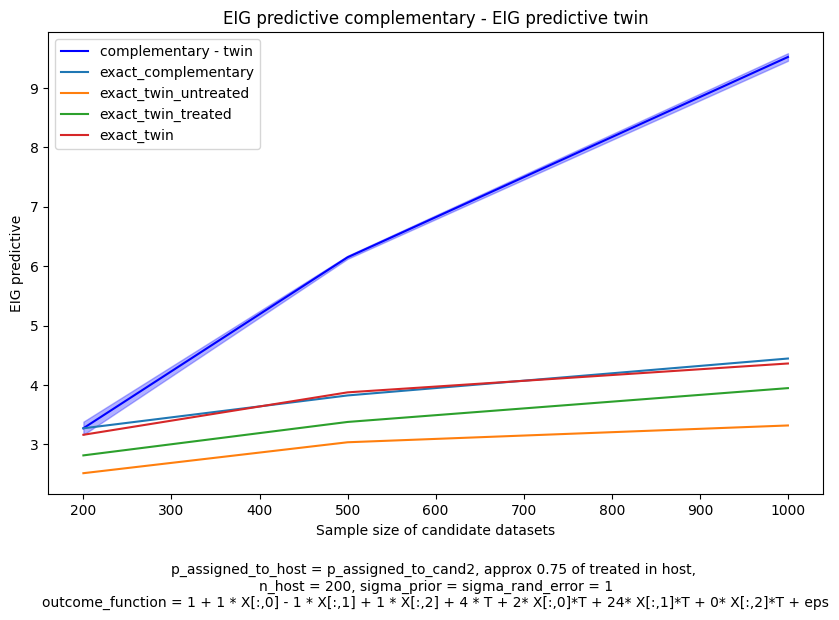

In [18]:
# path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
path_obs_closed_form = ""

plot_array(
    x=n_both_candidates_list,  # sample sizes
    arr=EIG_obs_closed_form_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG predictive"],
    dict_additional_plots=dict_additional_plots_obs_closed_from,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG predictive complementary - EIG predictive twin",
)

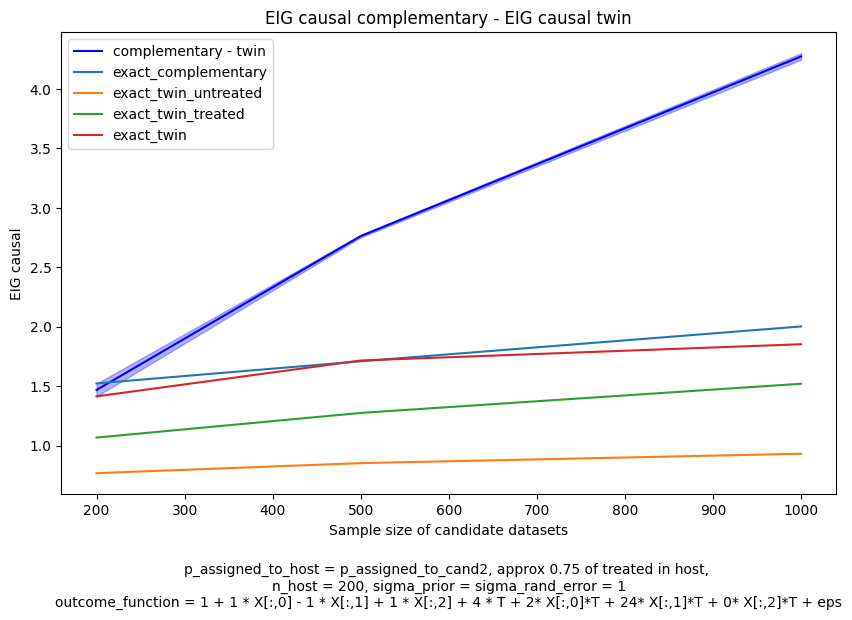

In [19]:
# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
path_caus_closed_form = 0

plot_array(
    n_both_candidates_list,
    EIG_caus_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG causal"],
    dict_additional_plots=dict_additional_plots_caus_closed_from,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG causal complementary - EIG causal twin",
)

### 2. EIG from samples for varying sample sizes

In [20]:
n_samples_outer_expectation_obs = 100
n_samples_inner_expectation_obs = 200
n_samples_outer_expectation_caus = 100
n_samples_inner_expectation_caus = 200

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [21]:
dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
    linear_eig_from_samples_varying_sample_size(
        exact_data,
        data_parameters,
        prior_hyperparameters,
        sampling_parameters
    )
)

In [22]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range(n_seeds):
    EIGs = linear_eig_from_samples_varying_sample_size(
        nonexact_data, data_parameters, prior_hyperparameters, sampling_parameters
    )
    EIG_obs_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


In [23]:
text_l1 = "p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host"
text_l2 = (
    "n_samples_inner_expectation_obs = "
    + str(n_samples_inner_expectation_obs)
    + "n_samples_outer_expectation_obs = "
    + str(n_samples_outer_expectation_obs)
    + ", n_host = "
    + str(n_host)
    + ", sigma_prior = sigma_rand_error = "
    + str(sigma_rand_error)
)
text_l4 = (
    "n_host = 200, sigma_prior = sigma_rand_error = 1, n_samples_inner_expectation_caus = "
    + str(n_samples_inner_expectation_caus)
)

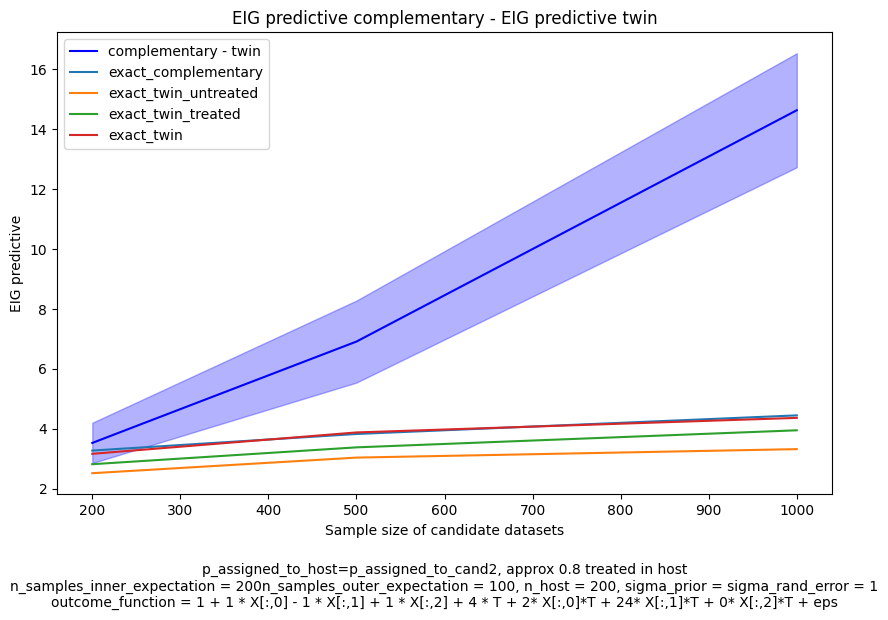

In [27]:
path_obs_closed_form = ""

plot_array(
    x=n_both_candidates_list,  # sample sizes
    arr=EIG_obs_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG predictive"],
    dict_additional_plots=dict_additional_plots_obs_closed_from,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3,
    title="EIG predictive complementary - EIG predictive twin",
)

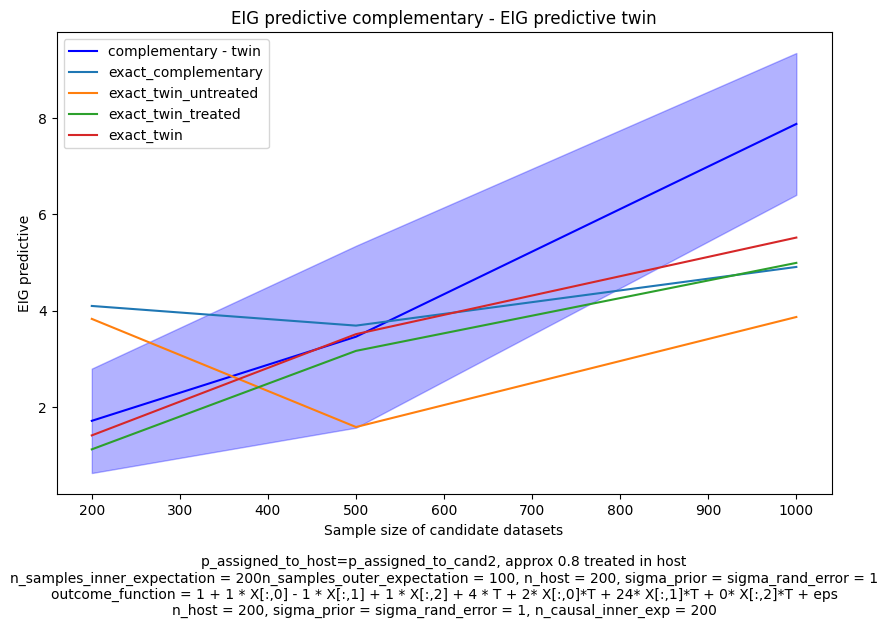

In [26]:
# path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
path_obs_samples = 0

plot_array(
    x = n_both_candidates_list,
    arr = EIG_caus_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG predictive"],
    dict_additional_plots=dict_additional_plots_obs_from_samples,
    text=text_l1 + "\n" + text_l2 + "\n" + text_l3 + "\n" + text_l4,
    title="EIG predictive complementary - EIG predictive twin"
)